# 파일 불러오기


DACON 내의 글자에 숨겨진 숫자 이미지 예측 데이터를 사용한다.

https://dacon.io/competitions/official/235626/data

##local drive에서 불러오기







In [ ]:
from google.colab import files
uploaded = files.upload()

Saving letter.zip to letter.zip


##google drive에서 불러오기

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!cp 'drive/MyDrive/data/letter.zip' ./

## 압축 해제

In [6]:
!unzip letter.zip
!ls -al

Archive:  letter.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               
total 55164
drwxr-xr-x 1 root root     4096 Aug 30 00:29 .
drwxr-xr-x 1 root root     4096 Aug 30 00:25 ..
drwxr-xr-x 4 root root     4096 Aug 25 13:35 .config
drwx------ 5 root root     4096 Aug 30 00:27 drive
-rw------- 1 root root 12292390 Aug 30 00:29 letter.zip
drwxr-xr-x 1 root root     4096 Aug 25 13:35 sample_data
-rw-r--r-- 1 root root   176379 Jul 31  2020 submission.csv
-rw-r--r-- 1 root root 39981059 Jul 31  2020 test.csv
-rw-r--r-- 1 root root  4004157 Jul 31  2020 train.csv


#CNN 적용

##python import

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.keras.utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##데이터 불러오기

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**train 데이터**

>id : data id

>digit : 숨겨진 숫자

>letter : 가리고 있는 알파벳

>0 ~ 783 : 28x28x1(단색) image pixel (0~255)

In [ ]:
train

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,1,2,1,3,3,4,4,3,4,1,0,4,4,4,1,1,1,2,3,4,1,2,3,3,2,3,1,3,4,0,...,2,4,1,1,1,1,2,3,1,2,0,2,4,1,0,3,4,4,0,1,3,3,3,3,2,0,3,3,3,2,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,1,4,2,0,3,3,2,2,1,2,3,2,2,4,1,0,4,1,0,2,0,3,0,2,3,3,3,4,0,4,...,0,1,1,1,1,3,0,4,2,0,4,3,1,4,0,1,0,0,3,3,0,0,1,3,3,1,2,0,3,2,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,4,3,4,0,1,3,4,1,0,2,2,0,0,3,3,2,0,4,3,2,3,4,3,1,1,4,4,4,1,1,...,3,2,4,3,2,1,1,0,4,0,4,4,1,3,3,1,3,4,1,0,2,4,1,2,4,4,4,3,4,2,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,3,0,1,4,0,0,0,2,3,1,1,1,0,2,4,1,0,3,0,1,2,4,1,4,3,1,4,4,4,0,...,0,0,2,0,2,3,2,0,3,0,1,0,1,0,1,2,3,2,1,1,0,0,3,1,4,1,1,2,1,3,2,3,1,1,0,4,1,4,3,1


**test 데이터**

>id : data id

>letter : 가리고 있는 알파벳

>0 ~ 783 : 28x28x1(단색) image pixel (0~255)

In [ ]:
test

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,1,0,0,2,4,3,2,0,1,3,1,1,0,2,0,4,4,2,3,0,2,2,2,2,1,3,2,2,4,1,...,1,4,4,2,1,3,4,2,3,2,4,2,3,1,1,3,2,4,3,1,2,1,3,0,4,2,2,1,1,4,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,4,3,2,3,3,2,2,0,0,0,2,4,3,0,2,0,2,4,2,3,3,1,4,2,2,3,2,2,2,0,...,1,1,0,2,1,4,4,4,0,1,2,4,4,4,1,2,4,2,1,4,1,0,1,0,4,2,0,0,3,4,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,4,4,1,0,0,1,2,1,2,2,0,3,0,4,0,2,3,3,4,1,2,0,1,2,4,3,1,3,3,1,...,1,3,3,2,1,3,0,3,2,3,2,4,2,0,4,2,2,2,1,1,0,3,0,2,1,4,3,2,3,4,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,1,2,2,3,1,2,3,4,1,3,1,0,3,3,1,2,4,3,4,1,0,0,1,1,0,4,1,3,2,2,...,0,4,0,2,4,2,1,3,2,0,1,3,0,4,1,4,2,3,3,2,2,1,4,2,0,3,0,3,2,4,2,0,0,4,3,3,3,4,4,2


## EDA

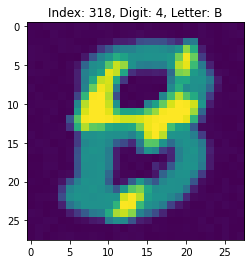

In [ ]:
idx = 318
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

train 데이터의 318행 자료를 이미지화함.

B 안에 숨겨진 4를 확인할 수 있다.

## 전처리

### Reshape & Normalization

csv 파일 내의 픽셀 정보를 reshape로 2D 단색 이미지 형태(28x28 matrix)로 변경하였다.

이후 각 픽셀값의 normalization을 진행하였다.

In [9]:
x = train.drop(['id', 'digit', 'letter'], axis=1).values
x = x.reshape(-1, 28, 28, 1)
x = x/255

y = train['digit']
y_id = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_id[i, digit] = 1


### dataset 분리

sklearn의 train_test_split을 이용하여 train.csv의 데이터셋을 8 : 2 로 분리하여 validation에 이용한다.

In [10]:
# train : validation : test = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y_id, train_size=0.6, 
                                                     random_state=1, shuffle=False)

## 모델 생성 - basline CNN model

4개의 convolution layer와 2개의 maxpooling layer를 가진 vanilla CNN에서 batch normalization을 추가한 형태

In [ ]:
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
model = create_cnn_model(x_train)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512   

## 모델 평가

### epoch 당 loss와 val_loss 값 도식화

epoch 50

NameError: ignored

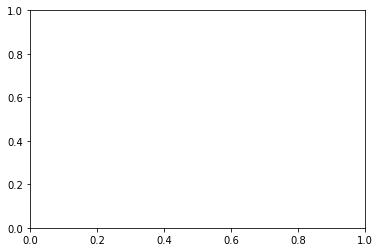

In [ ]:
fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

epoch 100

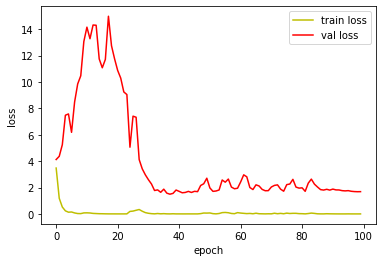

In [ ]:
fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

epoch 500

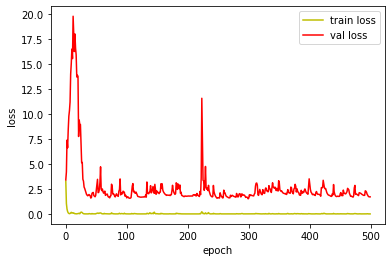

In [ ]:
fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

### epoch 당 accuracy와 val_accuracy 값 도식화

epoch 50

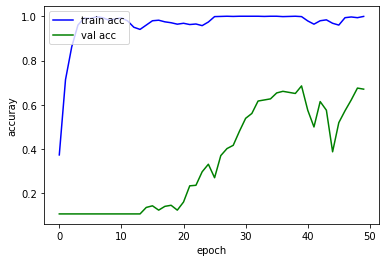

In [ ]:
fig, acc_ax = plt.subplots()

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left')

plt.show()

epoch 100

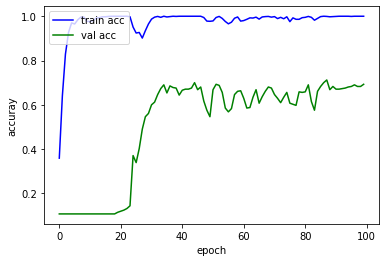

In [ ]:
fig, acc_ax = plt.subplots()

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left')

plt.show()

epoch 500

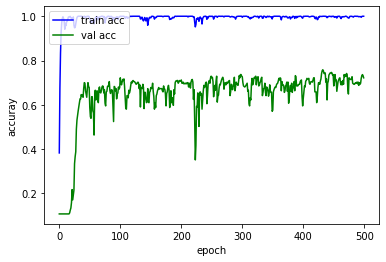

In [ ]:
fig, acc_ax = plt.subplots()

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left')

plt.show()

### test 데이터 평가

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print("loss=",loss)
print("acc=",acc)

13/13 [==============================] - 0s 6ms/step - loss: 1.5773 - accuracy: 0.6829
loss= 1.577276587486267
acc= 0.6829268336296082


# CNN 모델 개선

## 기존 모델

In [11]:
modelA = Sequential()
modelA.add( Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(28,28,1) ) )
modelA.add( BatchNormalization() )
modelA.add( Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu') )
modelA.add( MaxPooling2D(pool_size=(2,2)) )

modelA.add( BatchNormalization() )
modelA.add( Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu') )
modelA.add( BatchNormalization() )
modelA.add( Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu') )
modelA.add( MaxPooling2D(pool_size=(2,2)) )
modelA.add( Flatten() )

modelA.add( BatchNormalization() )
modelA.add( Dense( 1000, activation='relu') )

modelA.add( BatchNormalization() )
modelA.add( Dense( 10, activation='softmax') )

modelA.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 256)       1

In [12]:
modelA.compile( loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

histA = modelA.fit(x_train, y_train, epochs=50,verbose=1,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/50
20/20 [==============================] - 18s 63ms/step - loss: 3.4953 - accuracy: 0.3640 - val_loss: 3.0691 - val_accuracy: 0.1000
Epoch 2/50
20/20 [==============================] - 1s 33ms/step - loss: 1.0779 - accuracy: 0.6596 - val_loss: 4.9131 - val_accuracy: 0.1000
Epoch 3/50
20/20 [==============================] - 1s 33ms/step - loss: 0.5101 - accuracy: 0.8282 - val_loss: 5.6293 - val_accuracy: 0.1000
Epoch 4/50
20/20 [==============================] - 1s 33ms/step - loss: 0.2680 - accuracy: 0.9129 - val_loss: 8.7184 - val_accuracy: 0.1000
Epoch 5/50
20/20 [==============================] - 1s 33ms/step - loss: 0.1890 - accuracy: 0.9430 - val_loss: 8.8043 - val_accuracy: 0.1000
Epoch 6/50
20/20 [==============================] - 1s 33ms/step - loss: 0.1100 - accuracy: 0.9748 - val_loss: 11.6150 - val_accuracy: 0.1000
Epoch 7/50
20/20 [==============================] - 1s 35ms/step - loss: 0.0912 - accuracy: 0.9788 - val_loss: 11.3754 - val_accuracy: 0.1000
Epoch 8/50

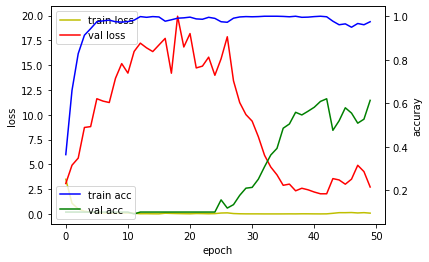

In [15]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(histA.history['loss'], 'y', label='train loss')
loss_ax.plot(histA.history['val_loss'], 'r', label='val loss')

acc_ax.plot(histA.history['accuracy'], 'b', label='train acc')
acc_ax.plot(histA.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [16]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('submission.csv')
submission['digit'] = np.argmax(modelA.predict(x_test), axis=1)
submission.head()
submission.to_csv('predict_A.csv', index=False)

## 개선 모델

In [17]:
modelB = Sequential()
    
modelB.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1)))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.3))

modelB.add(Conv2D(32,(3,3),activation='relu',padding='same'))
modelB.add(BatchNormalization())
modelB.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
modelB.add(BatchNormalization())
modelB.add(Conv2D(32,(3,3),activation='relu',padding='same'))
modelB.add(BatchNormalization())
modelB.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
modelB.add(BatchNormalization())
modelB.add(MaxPooling2D((5,5)))
modelB.add(Dropout(0.3))

modelB.add(Conv2D(64,(3,3),activation='relu',padding='same'))
modelB.add(BatchNormalization())
modelB.add(Conv2D(128,(3,3),activation='relu',padding='same')) 
modelB.add(BatchNormalization())
modelB.add(MaxPooling2D((3,3)))
modelB.add(Dropout(0.3))

modelB.add(Flatten())

modelB.add(Dense(128,activation='relu'))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.3))
modelB.add(Dense(64,activation='relu'))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.3))

modelB.add(Dense(10,activation='softmax'))

In [18]:
modelB.compile( loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

histB = modelB.fit(x_train, y_train, epochs=100,verbose=1,batch_size=64,validation_data=(x_val,y_val))

Epoch 1/100
20/20 [==============================] - 2s 39ms/step - loss: 3.1115 - accuracy: 0.1010 - val_loss: 2.3242 - val_accuracy: 0.1000
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 2.8534 - accuracy: 0.1450 - val_loss: 2.3665 - val_accuracy: 0.1000
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 2.7258 - accuracy: 0.1368 - val_loss: 2.4177 - val_accuracy: 0.1000
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 2.6519 - accuracy: 0.1474 - val_loss: 2.4510 - val_accuracy: 0.1000
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 2.5365 - accuracy: 0.1482 - val_loss: 2.5016 - val_accuracy: 0.1000
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 2.4197 - accuracy: 0.1873 - val_loss: 2.5779 - val_accuracy: 0.1000
Epoch 7/100
20/20 [==============================] - 0s 13ms/step - loss: 2.3610 - accuracy: 0.2036 - val_loss: 2.5929 - val_accuracy: 0.1000
Epoch 

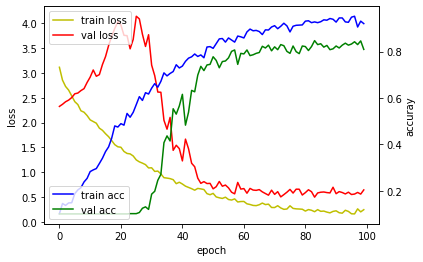

In [20]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(histB.history['loss'], 'y', label='train loss')
loss_ax.plot(histB.history['val_loss'], 'r', label='val loss')

acc_ax.plot(histB.history['accuracy'], 'b', label='train acc')
acc_ax.plot(histB.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [21]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('submission.csv')
submission['digit'] = np.argmax(modelB.predict(x_test), axis=1)
submission.head()
submission.to_csv('predict_B.csv', index=False)

# Test accuracy 비교

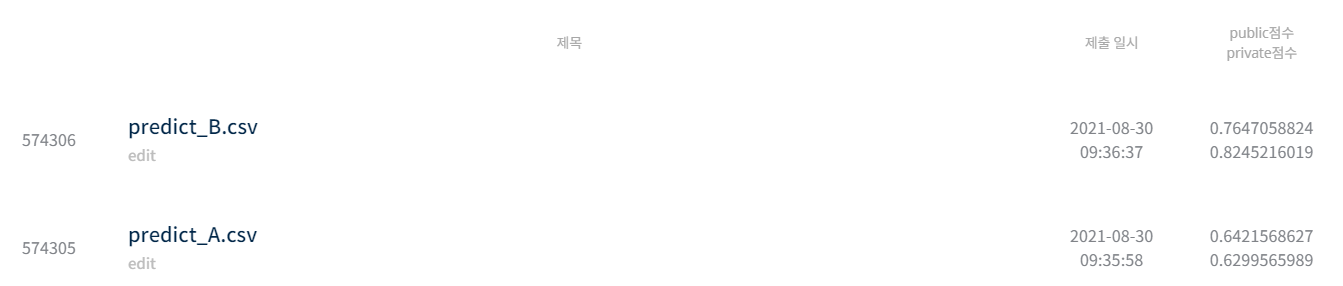

# **참고 자료**

dacon base line (CNN model) : 
https://dacon.io/competitions/official/235626/codeshare/1555?page=1&dtype=recent

train_test_split : 
https://teddylee777.github.io/scikit-learn/train-test-split

loss & accuracy data plot : 
https://tykimos.github.io/2017/07/09/Training_Monitoring/

Deep CNN improvement :
https://buomsoo-kim.github.io/keras/2018/05/05/Easy-deep-learning-with-Keras-11.md/
